In [1]:
import os
import sys
import xarray as xr
import numpy as np
from numpy import unravel_index
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import datetime
from pathlib import Path
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
from matplotlib.patches import FancyArrowPatch

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings
warnings.filterwarnings('ignore')

In [2]:
def write_histogram_track(buoy_track, omega_track, cloudnumber_track, tb_track, bins_bl,
                          mask_type='all'):
    """
    write out histogram of BL values by the given bins
    based on the variable saved in each "MERGED.nc" X(41,41,27) 
    """
    buoy_samples = np.zeros(len(bins_bl)-1)
    omega_sum = np.zeros((len(omega_track.level),len(bins_bl)-1))
   
    BL = buoy_track.Buoy_TOT
    omega = omega_track.w
    mcsmask = cloudnumber_track.cloudtracknumber_nomergesplit
    tb = tb_track.tb

    if mask_type == 'mcs':
        BL_cond = BL.where(mcsmask > 0)
        omega_cond = omega.where(mcsmask > 0)
    if mask_type == 'nonmcs':
        BL_cond = BL.where(tb < 241)
        BL
   
    # get 1-D BL values over the specified region
    BL_1d = np.reshape(Buoy_sub.values, (len(Buoy_sub.lat)*len(Buoy_sub.lon)))
    omega_1d = np.reshape(omega_sub.values, (len(omega_sub.level),len(Buoy_sub.lat)*len(Buoy_sub.lon))) # transpose to match BL_1d (lat,lon)

    for n in range(len(bins_bl)-1):
        idx = np.where(np.logical_and(BL_1d >= bins_bl[n], BL_1d < bins_bl[n+1]))[0]
        buoy_samples[n] = len(idx)
        omega_sum[:,n] = np.sum(omega_1d[:,idx], axis=1)
    
    return (buoy_samples, omega_sum)

In [96]:
# defined tropical regions
WPC = [-10,10,110,140]
IND = [-10,5,70,90]
EPC = [0,10,240,260]
ATL = [0,10,320,340]
WAF = [-10,10,0,30]
MC  = [-7,7,95,125]
AMZ = [-10,5,285,310]

#BL_dir = Path('/neelin2020/ERA-5_buoy/layer_thetae')
#data_temp = xr.open_dataset(BL_dir / 'era5_2layers_thetae_2008_06_19.nc').sel(lat=slice(-30,30))
lon_re = np.arange(0,360,0.25)
lat_re = np.arange(-30,30.25,0.25)

# processing data writeout
bins_bl = np.arange(-30,10,0.25) # degree Kelvin
buoy_samples = np.zeros((7,len(bins_bl)-1)) # 7 tropical regions
omega_sum = np.zeros((7,27,len(bins_bl)-1)) # levels, BL bins

year = 2011

print('processing year: {}'.format(year))
buoy_dir = Path('/neelin2020/ERA-5_buoy/layer_thetae/')
era5_dir = Path('/neelin2020/ERA-5/NC_FILES/{}/'.format(year))
omega_dir = Path('/scratch/wmtsai/ERA-5/NC_FILES/{}/'.format(year))
out_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/buoy_omega_1D_multiregions')

for month in np.arange(1,13):
    print('month: {}'.format(str(month).zfill(2)))

    # 1. 0.25-deg, 3-hourly buoyancy measure: BL = BL,cape - BL,subsat
    buoy_files = list(buoy_dir.glob('era5_2layers_thetae_{}_{}_*.nc'.format(year,str(month).zfill(2))))
    data_buoy = xr.open_mfdataset(buoy_files).sel(lat=slice(-30,30))
    data_buoy = data_buoy.interp(lat=lat_re, lon=lon_re)

    data_sp = xr.open_dataset(era5_dir / 'era-5.sp.{}.{}.nc'.format(year,str(month).zfill(2))).sel(latitude=slice(30
    ,-30)).SP/100 # hPa
    data_sp = data_sp.reindex(latitude=sorted(list(data_sp.latitude))) # fliping latitude order: -30 to 30
    #data_sp = data_sp.interp(latitude=lat_re.values, longitude=lon_re.values)
    data_sp = data_sp.rename({'latitude': 'lat', 'longitude': 'lon'})
    sp = data_sp.sel(time=data_buoy.time)

    thetae_bl = data_buoy.thetae_bl
    thetae_sat_lt = data_buoy.thetae_sat_lt
    thetae_lt = data_buoy.thetae_lt

    delta_pl=sp-100-500 # top at 500hPa
    delta_pb=100
    wb=(delta_pb/delta_pl)*np.log((delta_pl+delta_pb)/delta_pb)
    wl=1-wb

    Buoy_CAPE = wb * ((thetae_bl-thetae_sat_lt)/thetae_sat_lt) * 340
    Buoy_SUBSAT = wl * ((thetae_sat_lt-thetae_lt)/thetae_sat_lt) * 340
    Buoy_TOT = (Buoy_CAPE - Buoy_SUBSAT).compute() # degree Kelvin (K)

    ##########



    ##########

    data_omega = xr.open_dataset(omega_dir / 'era-5.omega.{}.{}.nc'.format(year,str(month).zfill(2))).sel(latitude=slice(30
    ,-30)).w # pa/s
    data_omega = data_omega.reindex(latitude=sorted(list(data_omega.latitude)), level=sorted(ds.level, reverse=True)) # fliping latitude order: -30 to 30
    #data_omega = data_omega.interp(latitude=lat_re.values, longitude=lon_re.values)
    data_omega = data_omega.rename({'latitude': 'lat', 'longitude': 'lon'})
    omega = data_omega.sel(time=data_buoy.time)

#        3. sampling by BL bins over regions
#        WPC = [lat_s, lat_n, lon_s, lon_n]
    for t in Buoy_TOT.time:
        for n, geo_info in enumerate([WPC, IND, EPC, ATL, WAF, MC, AMZ]):
            (b_samples, omega_samples_sum) = write_histogram_regions(Buoy_TOT.sel(time=t)
                                                        , omega.sel(time=t), bins_bl, geo_info)

            buoy_samples[n,:] += b_samples
            omega_sum[n,:,:] += omega_samples_sum

# writeout data
ds = xr.Dataset(data_vars = dict(samples = (['region','BL_bins'], buoy_samples),
                                 omega_sum = (['region','level','BL_bins'], omega_sum)),
                coords = dict(BL_bins = (['BL_bins'], bins_bl[:-1]),
                              level = (['level'], omega.level.values),
                              region = (['region'], ['WPC','IND','EPC','ATL','WAF','MC','AMZ'])),
                attrs = dict(description = 'buoy-omega relationship in tropical regions',
                                bins_unit = 'degree Kelvin')
                ) 

ds.to_netcdf(out_dir / 'buoy_omega_1D_multiregions.{}.nc'.format(year))

processing year: 2011
month: 01
month: 02
month: 03
month: 04
month: 05
month: 06
month: 07
month: 08
month: 09
month: 10
month: 11
month: 12


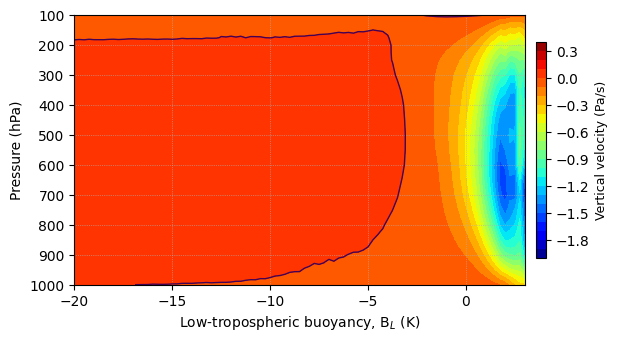

In [5]:
# load data
out_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/buoy_omega_1D_multiregions')

ds_buoy_omega = xr.open_dataset(out_dir / 'buoy_omega_1D_multiregions.2014.nc')
cond_omega = ds_buoy_omega.isel(region=0).omega_sum/ds_buoy_omega.isel(region=0).samples

fig = plt.figure(figsize=(7,3.5))
plt.contourf(ds_buoy_omega.BL_bins, ds_buoy_omega.level, cond_omega, levels=np.arange(-2,0.5,0.1), 
             cmap='jet')
cbar = plt.colorbar(pad=0.02, shrink=0.8)
cbar.set_label('Vertical velocity (Pa/s)',fontsize=9)
plt.contour(ds_buoy_omega.BL_bins, ds_buoy_omega.level, cond_omega, levels=[0], color=['k'], linewidths=1),
plt.ylim([1000,100])
plt.xlim([-20,3])
plt.ylabel('Pressure (hPa)', fontsize=10)
plt.xlabel('Low-tropospheric buoyancy, B$_{L}$ (K)', fontsize=10)
plt.grid(ls=':',lw=0.5)
plt.show()

In [12]:
BL_dir = Path('/neelin2020/ERA-5_buoy/layer_thetae')
data_temp = xr.open_dataset(BL_dir / 'era5_2layers_thetae_2008_06_19.nc').sel(lat=slice(-30,30))
lon_re = np.arange(0,360,0.25)
lat_re = np.arange(-30,30.25,0.25)
tmp = data_temp.interp(lon=lon_re, lat=lat_re)

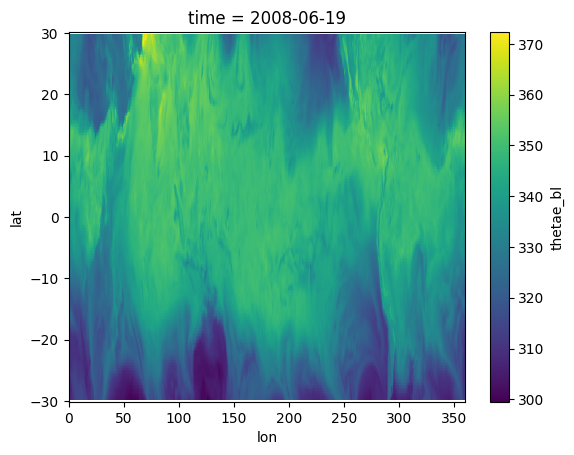

In [14]:
tmp.isel(time=0).thetae_bl.plot()